# Книжка направлена на валидацию полученной сети

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.metrics import roc_curve, auc
import matplotlib.patches as patches

from nets_algo import *

import os
import os.path as os_path

cpfn = "diplom_project"

curr_dir = os.getcwd()
curr_dir = os_path.join(curr_dir[:curr_dir.find(cpfn)], cpfn)
data_storage = os_path.join(curr_dir, "data_storage")
inc_los_dir = os_path.join(data_storage, 'inc_los_data')
fit_and_valid_fold = os_path.join(data_storage, "fiting_and_valid")

# Загрузка выборки

Тестовые данные

In [3]:
names = ["X_test", "Y_test", "X_train", "Y_train"]

pand_dfs = { 
    name : pd.read_csv(
        os_path.join(fit_and_valid_fold, name + '.csv'), index_col = 0) 
    for name in names}

np_arrs = {df: np.array(pand_dfs[df])  for df in pand_dfs}

# последним столбцом я специально отложил индекст для того
# чтобы достать данные которые не должны были участвовать в
# обучении но могут пригодиться в валидации модели
#test_index, train_index = (X_test[:, -1], X_train[:, -1])
# X_test, X_train = (np.delete(arr, -1, axis = 1) for arr in [X_test, X_train])

X_full, y_full = (np.concatenate(lst) for lst in 
   [[np_arrs['X_test'], np_arrs['X_train']], 
    [np_arrs['Y_test'], np_arrs['Y_train']]])


X_test_tens, y_test_tens, X_full_tens, y_full_tens =\
    (torch.tensor(arr.astype('float32')) for arr in [
    np_arrs['X_test'], np_arrs['Y_test'], 
    X_full, y_full])

# Функции для работы с валидацей моделей

## ROC кривая и AUC

In [4]:
def plot_roc(fpr, tpr):
    plt.figure(figsize = [10,10])
    plt.fill_between(
        fpr, tpr, hatch = '\\\\',
        alpha = 0
    )
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], '--')
    plt.margins(x = 0 , y = 0)
    plt.legend(
        [
            "AUC = " + str(np.round(auc(fpr, tpr), 3)),
            "ROC модели", 
             "ROC случаного классификатора"
        ],
        fontsize = 15
    )
    plt.xlabel("$FPR$", loc = "right", fontsize = 12)
    plt.ylabel("$TPR$", loc = "top", fontsize = 12)

## KS и оптимальная точка отсечения

In [5]:
def plot_KS(
    p, Nc_distr, Pc_distr, ax,
    N_plot_param = {},
    P_plot_param = {},
    x_lab_param = {}, 
    label_param = {}
):
    '''Нанесение KS на график'''
    ax.plot(p, Nc_distr, **N_plot_param)
    ax.plot(p, Pc_distr, **P_plot_param)
    
    plt.xlabel("$PD$", **x_lab_param)
    
    pKS = np.argmax(np.abs(Nc_distr - Pc_distr))
    
    KS_arrow = patches.FancyArrowPatch(
        (p[pKS], Nc_distr[pKS]), (p[pKS], Pc_distr[pKS]), 
        arrowstyle='<->', mutation_scale=20
    )
    
    ax.text(
        p[pKS], (Nc_distr[pKS] + Pc_distr[pKS]) / 2, "KS",
        **label_param
    )
    plt.margins(x = 0 , y = 0)
    
    # откакладываем и подписываем предсказания
    plt.text(p[pKS], 0.02, str(np.round(p[pKS],3)), fontsize = 14)
    plt.plot([p[pKS]]*2, [Nc_distr[pKS], 0], '--', color = 'black')
    plt.text(0.002, Nc_distr[pKS] + 0.01, str(np.round(Nc_distr[pKS], 3)))
    plt.plot([0,p[pKS]], [Nc_distr[pKS]]*2, '--', color = 'black')
    plt.text(0.002, Pc_distr[pKS] + 0.01, str(np.round(Pc_distr[pKS], 3)))
    plt.plot([0,p[pKS]], [Pc_distr[pKS]]*2, '--', color = 'black')
    
    ax.add_patch(KS_arrow)
    
    plt.legend([
        'Доля ошибочно предсказанных дефолтов',
        'Доля правильно предсказанных дефолтов'
    ], fontsize = 14)

# Модель 1 скрытый слой 113 нейронов

In [6]:
model = ResultNet([113, 113])
model.load_state_dict(torch.load('model 1lay 113 neurons'))

<All keys matched successfully>

Точки отсечения выбираем по полным данным

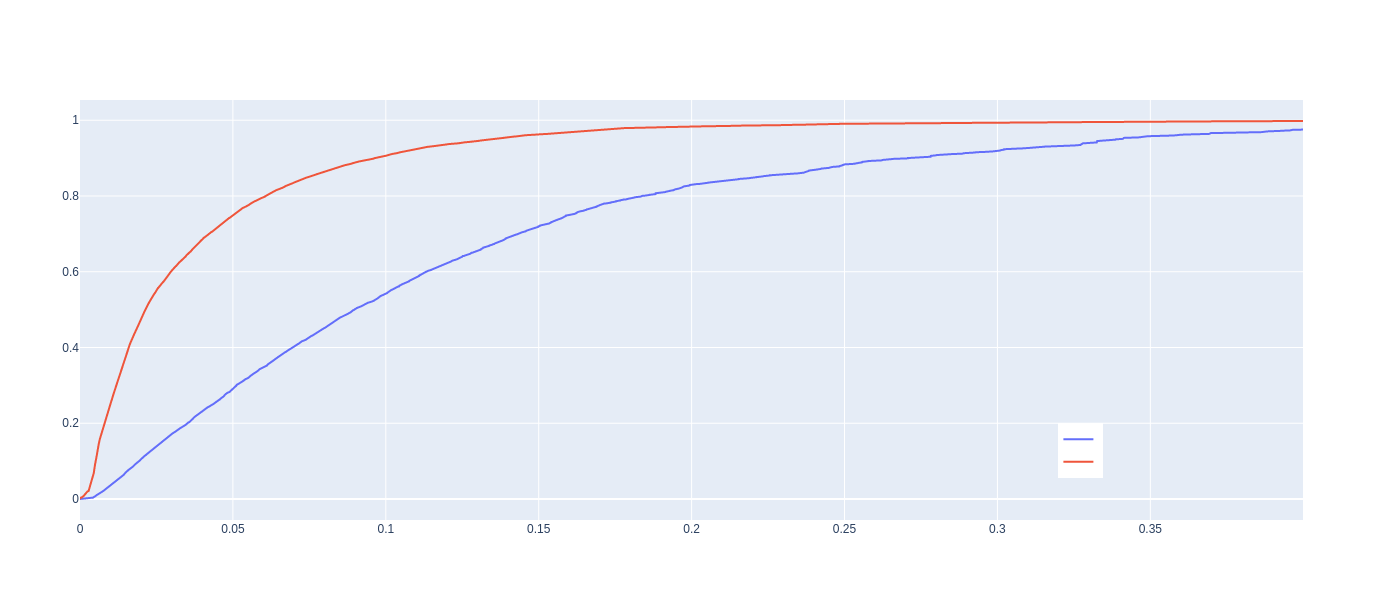

In [8]:
p_hat = model(X_full_tens).detach().numpy()
fpr, tpr, threholds = roc_curve(y_full, p_hat)
threholds = np.sort(threholds)

sel_cond = threholds < 0.4

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = threholds[sel_cond], 
    y = fpr[sel_cond],
    name = 'r$\hat{F}_х(p)$'))
fig.add_trace(go.Scatter(
    x = threholds[sel_cond], 
    y = tpr[sel_cond],
    name = r'$\hat{F}_д(p)$'))

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    legend = dict(
        y = 0.1,
        x = 0.8,
        font_size = 15
    ),
)

# fig.write_html("/home/dranik/KFA/university/test.html")
# pltly.express.line(x = threholds, y = fpr)
# pltly.express.line(x = threholds, y = tpr)
# pltly.plot(threholds, fpr)

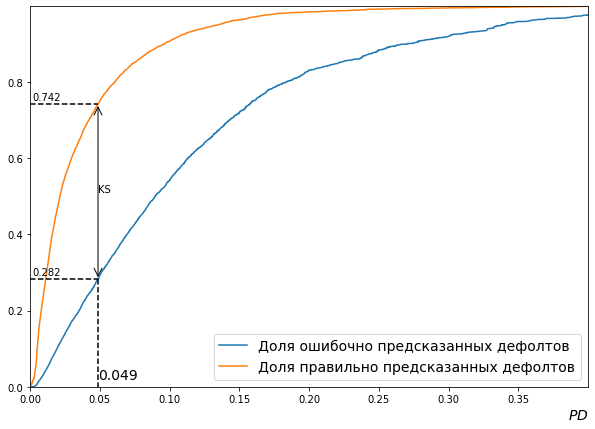

In [77]:
plt.figure(figsize = [10,7])

sel_cond = threholds < 0.4

plot_KS(
    threholds[sel_cond], 
    fpr[sel_cond], 
    tpr[sel_cond], 
    plt.subplot(111),
    x_lab_param = {
        'loc':'right',
        'fontsize':14
    }
)

p = threholds[np.argmax(np.abs(fpr - tpr))]
plt.savefig("validation_results/1lay_113_KS_plot.png")

AUC строим на тестовых данных

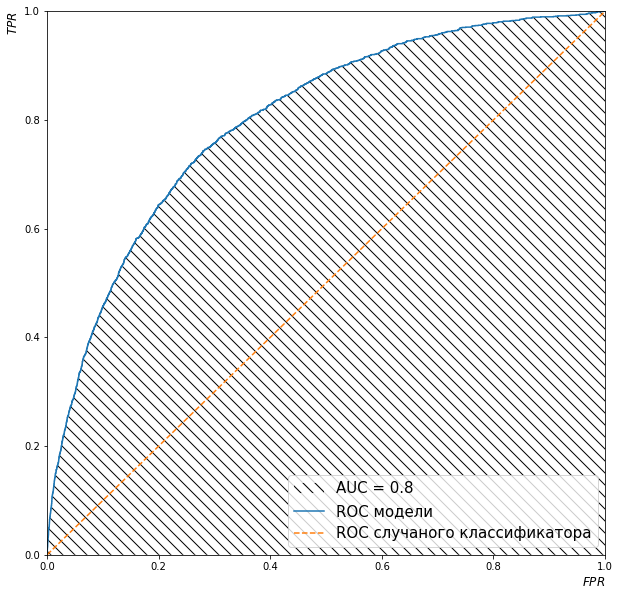

In [7]:
p_hat = model(X_test_tens).detach().numpy()
fpr, tpr, threholds = roc_curve(np_arrs['Y_test'], p_hat)
fpr = fpr[1:]
tpr = tpr[1:]
threholds = threholds[1:]

plot_roc(fpr, tpr)
plt.savefig("validation_results/1lay_133_roc.png")

Сформируем информацю о том как модель предсказывает

In [8]:
y_pred_test = (p_hat > p).astype('int')
abs_cross_tab = pd.crosstab(np_arrs['Y_test'].ravel(), y_pred_test.ravel())
abs_cross_tab.to_excel("validation_results/fp_tp.xlsx")

In [9]:
abs_cross_tab

col_0,0,1
row_0,,
0,42794,9556
1,674,1067


In [10]:
rel_cross_tab =\
    abs_cross_tab.apply(lambda x: x/np.sum(abs_cross_tab, axis = 1))
rel_cross_tab.to_excel("validation_results/fpr_tpr.xlsx")

In [11]:
rel_cross_tab

col_0,0,1
row_0,,
0,0.817459,0.182541
1,0.387134,0.612866


# Попробуем подобрать точку отсечения опираясь на минимальные потери по процентам и невыплате

In [18]:
prof_los_data = pd.read_csv(inc_los_dir + ".csv", index_col = 0)

In [19]:
def compute_fin_profits(p_bar):
    '''Для вычисления финансовых выйгрышей'''
    # p_bar - выбранная точка отсечения
    result = {}
    y_hat = p_hat > p_bar
    
    # ошибки первгого рода - ошибочно предсказанные дефолты
    # потери на процентах от ипользования этого классфификатора
    error1_ind = pand_dfs["X_test"].loc[
        np.logical_and((y_hat == 1), (np_arrs['Y_test'] == 0)),:].index
    result["losses"] = prof_los_data.\
        loc[prof_los_data.index.isin(error1_ind)]['Выйгрыш_потеря'].sum()
    
    # ошибки второго рода - обшибочно выданные кредиты
    # получаем потери от невозврата этих задолженностей
    error2_ind = pand_dfs["X_test"].loc[
        np.logical_and((y_hat == 0), (np_arrs['Y_test'] == 1)),:].index
    result["profits"] = prof_los_data.\
        loc[prof_los_data.index.isin(error2_ind)]['Выйгрыш_потеря'].sum()
    
    return result

In [56]:
result_frame = pd.DataFrame(
    columns = ['profits', 'losses'],
    dtype = 'float32')
p_arr = np.linspace(0,1, 1000)

for p in p_arr:
    result_frame.loc[p, :] = compute_fin_profits(p)

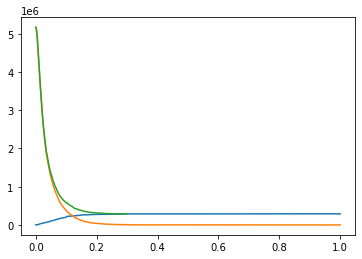

In [58]:
plt.plot(result_frame.index, np.abs(result_frame['profits']))
plt.plot(result_frame.index, result_frame['losses'])

result_frame = result_frame.loc[result_frame.index < 0.3]

plt.plot(
    result_frame.index, result_frame['losses'] + 
    np.abs(result_frame['profits']))

In [60]:
(result_frame['losses'] + \
np.abs(result_frame['profits'])).idxmin()

0.26926926926926925